In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime
import os

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
import sys
from keras.models import model_from_json
from keras.models import load_model
from datetime import datetime as dt
sys.path.append('C:/Users/tmatsumoto/AppData/code/seq2seq')

In [3]:
def _load_data(X,Y, n_prev=100):
    docX, docY = [], []
    for i in range(X.shape[0]-n_prev):
        docX.append(X[i:i+n_prev])
        docY.append(Y[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

In [6]:
n_train = 24000

#学習用データの作成
csv_path = 'C:/Users/tmatsumoto/AppData/code/seq2seq/currency_data/USDT_BTC_5minutes_1year_20180128_2.csv'
coin_data = pd.read_csv(csv_path, encoding='UTF-8')
coin_data['DATE'] = coin_data.DATE.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

coin_data_ = coin_data.drop(coin_data.index[len(coin_data)-1])
coin_data_ = coin_data_.drop(["DATE","USDT_BTC_close_after_5min_diff",
                                "USDT_BTC_close_after_5min_ratio",
                                "USDT_BTC_close_after_5min_log",
                                "USDT_BTC_close_after_5min_flag"], axis=1)

coin_data_y = coin_data_['USDT_BTC_close_after_5min']
coin_data_x = coin_data_.drop(["USDT_BTC_close_after_5min"], axis=1)

#不要なカラムを削除
#    coin_data = coin_data.drop(["DATE","USDT_BTC_close_after_30min","USDT_BTC_close_after_30min_ratio"], axis=1)
#行列に変形
coin_data_matrix = coin_data_.as_matrix()

#学習データとテストデータに分解する
coin_data_all = coin_data_matrix[n_train:]

#データを正規化
scaler = MinMaxScaler()
yscaler = MinMaxScaler()
length_of_sequences = 50
batch_train = 20000

coin_data_train = coin_data_all[:batch_train]

x_train = coin_data_train[:,:-1].astype(np.float32)
x_train = scaler.fit_transform(x_train)

y_train = coin_data_train[:,-1].astype(np.float32)
y_train = yscaler.fit_transform(y_train)

train_X ,train_Y = _load_data(x_train, y_train, length_of_sequences)

coin_data_val = coin_data_all[batch_train:]

x_val = coin_data_val[:,:-1].astype(np.float32)
x_val = scaler.transform(x_val)

y_val = coin_data_val[:,-1].astype(np.float32)
y_val = yscaler.transform(y_val)
val_X ,val_Y = _load_data(x_val, y_val, length_of_sequences)

C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d ar

In [8]:
train_X.shape

(19950, 50, 154)

In [9]:
model_path = 'C:/Users/tmatsumoto/AppData/code/seq2seq/model/lstm_model_case11.h5'
model = load_model(model_path)

In [10]:
pred_data = model.predict(val_X)

In [11]:
obs_unscale = yscaler.inverse_transform(val_Y)
pred_unscale = yscaler.inverse_transform(pred_data)

C:\Users\tmatsumoto\AppData\WinPython-64bit-3.5.4.0Qt5\python-3.5.4.amd64\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [18]:
len(obs_data)

2029

In [17]:
obs_data = coin_data.drop(coin_data.index[:n_train+batch_train+50])
obs_data = obs_data.drop(obs_data.index[len(obs_data)-1])

obs_data = obs_data[["DATE","USDT_BTC_close_after_5min"]]
obs_data.reset_index(drop=True, inplace=True)

obs_data["USDT_BTC_close_after_5min_1"] = obs_unscale
obs_data["USDT_BTC_close_after_5min_pred"] = pred_unscale

In [19]:
obs_data.DATE = obs_data.DATE.apply(lambda x: dt.strptime(str(x), '%Y-%m-%d %H:%M:%S'))

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib.ticker import *
%matplotlib inline

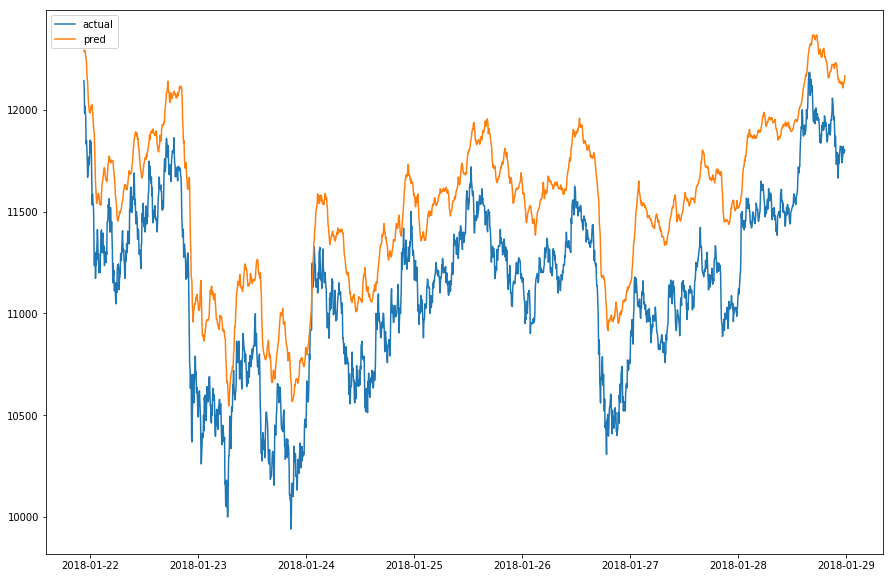

In [22]:
#学習期間の全データをプロット
plt.figure(figsize=(15,10))

plt.plot(obs_data["DATE"],obs_data["USDT_BTC_close_after_5min_1"], label='actual')
plt.plot(obs_data["DATE"],obs_data["USDT_BTC_close_after_5min_pred"], label='pred')

p = plt.legend()

In [44]:
#データ加工用にdateをindex化
obs_data2 = obs_data.set_index(['DATE'])

#上がるか下がるかがどれだげ的中しているか算出
def get_diff(baseday, delta, diff_value, target_column):
    targetday = baseday - datetime.timedelta(minutes=delta)
    try:
        targetday_list = obs_data2.loc[(targetday)]
    except:
        return np.NaN
    return 2 if (float(diff_value) - float(targetday_list[target_column])) > 0 else 1

In [45]:
delta = 5
obs_data['USDT_BTC_close_after_5min_diff'] = obs_data.apply(lambda x:get_diff(x.DATE, delta, x["USDT_BTC_close_after_5min"], "USDT_BTC_close_after_5min"), axis=1)
obs_data['USDT_BTC_close_after_5min_pred_diff'] = obs_data.apply(lambda x:get_diff(x.DATE, delta, x["USDT_BTC_close_after_5min_pred"], "USDT_BTC_close_after_5min_pred"), axis=1)

In [41]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()

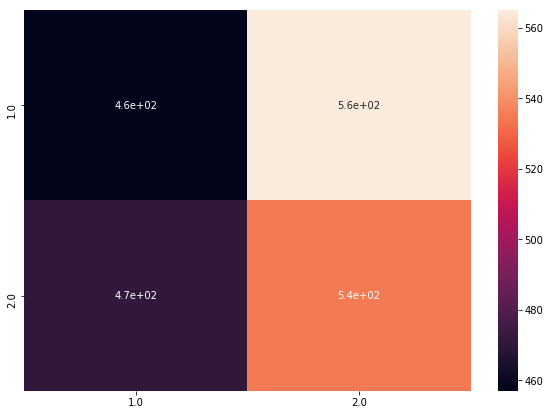

In [50]:
obs_data3 = obs_data.drop(coin_data.index[0])
print_cmx(obs_data3['USDT_BTC_close_after_5min_diff'].tolist(),obs_data3['USDT_BTC_close_after_5min_pred_diff'].tolist())

In [53]:
#予測対象期間のみに絞る

date_min = obs_data.loc[370].DATE
date_max = obs_data.loc[400].DATE
obs_data_pred = obs_data[(obs_data.DATE >= date_min) & (obs_data.DATE <= date_max)]

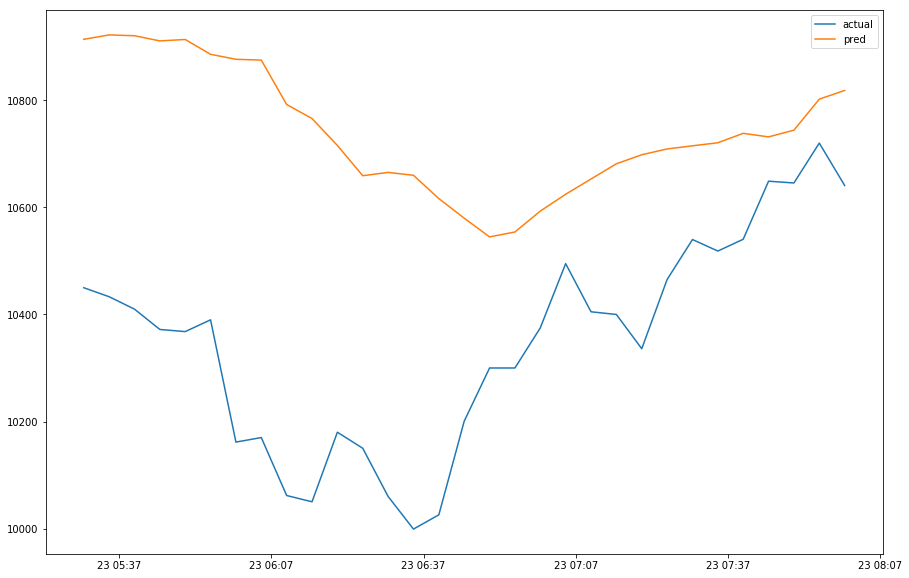

In [54]:
plt.figure(figsize=(15,10))

#mape = (np.abs(obs_data_pred["BTCUSDT_close_after_1min"] - obs_data_pred["USDT_BTC_close_after_5min_pred"]) / obs_data_pred["BTCUSDT_close_after_1min"]).mean() * 100

plt.plot(obs_data_pred["DATE"],obs_data_pred["USDT_BTC_close_after_5min_1"], label='actual')
plt.plot(obs_data_pred["DATE"],obs_data_pred["USDT_BTC_close_after_5min_pred"], label='pred')

#plt.title("MAPE:{1:.2f}%".format("", mape), fontsize=18)
p = plt.legend()